In [1]:
# Fill in your name using the format below and student ID number
your_name = "Maas, Yuri"
student_id = "1024785"

In [49]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Code required for my RTX to work on CNNs
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print('Done')

Done


In [6]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [7]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Yuri, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [8]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = 'C:/Users/Yuri/Documents/Python/School/WIDM3'

In [9]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [10]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [11]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [12]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [13]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

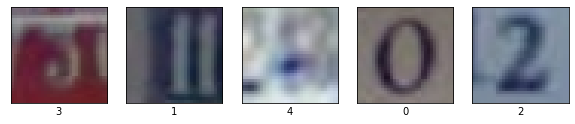

In [14]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=2, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=2, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 2000)              6146000   
_________________________________________________________________
dense_38 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_39 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_40 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_41 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_42 (Dense)     

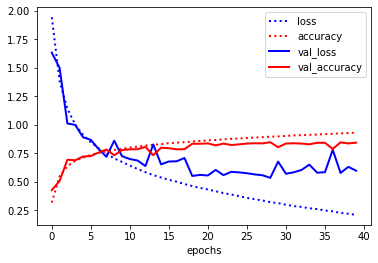

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout

def build_model_1_1():
  model = Sequential()
  # Reshape the 32 by 32 with 3 color channels 3d tensor to a 1d tensor with 3072 values per picture
  model.add(Reshape((32*32*3, ), input_shape=(32,32,3)))
  model.add(Dense(2000, activation='relu'))
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(500, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=40, batch_size=32)
answer_q_1_1 = """The first layer should have many nodes to avoid information bottlenecks. Thus 2000 nodes were used, this also keeps the parameters limited for the storage file. Any subsequent layer until the last layer has half the nodes of the predecessor to preserve a data flow. The last layer only has 10 nodes with softmax, since we only have 10 output classes. Finally, sgd with crossentropy is used to quickly converge. The model has an accuracy of ~84% after 40 epochs, but starts overfitting after 25 epochs"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

def preprocess(X_train, X_val, y_train, y_val):
    X_train_gray = rgb2gray(X_train)
    X_val_gray = rgb2gray(X_val)
    return X_train_gray, X_val_gray, y_train, y_val

print(np.sum(y_train, axis=0))

[12134.  9430.  7282.  6388.  5930.  4930.  4873.  4291.  4003.  4283.]


Loading model from file
Success!
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_22 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_127 (Dense)            (None, 2000)              2050000   
_________________________________________________________________
dense_128 (Dense)            (None, 1000)              2001000   
_________________________________________________________________
dense_129 (Dense)            (None, 500)               500500    
_________________________________________________________________
dense_130 (Dense)            (None, 250)               125250    
_________________________________________________________________
dense_131 (Dense)            (None, 100)               25100     
_________________________________________________________________
dense_132 (Dense)   

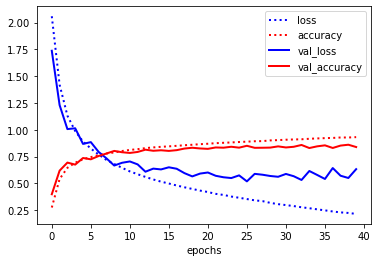

In [18]:
# Replace with the preprocessed data
preprocessed_split = preprocess(X_train, X_val, y_train, y_val)

# Adjusted model
def build_model_1_2():
  # Copy of model 1_1 with different input shape
  model = Sequential()
  # Reshape the 32 by 32 with 3 color channels 3d tensor to a 1d tensor with 3072 values per picture
  model.add(Reshape((32*32, ), input_shape=(32,32,1)))
  model.add(Dense(2000, activation='relu'))
  model.add(Dense(1000, activation='relu'))
  model.add(Dense(500, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=40, batch_size=32)
answer_q_1_2 = """The only preprocessing used is the grayscale converter to simplify and normalize the images. The model performs marginally better with the preprocessing, as the accuracy is 2% higher. However, this model does only use half of the parameters that model 1_1 used (4000000 vs 8000000). Rotation, sliding and zoomin of images was tried but decreased accuracy because the images are already centered on the numbers. Class sampling methods were not required as all classes are represented enough in the data, even though there are less 6-7-8-9 than the others"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2400)              2460000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2400)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1400)              3361400   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1400)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 700)               980700    
_________________________________________________________________
dropout_12 (Dropout) 

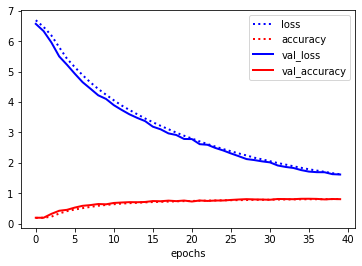

In [19]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import Hyperband, RandomSearch

def build_model_1_3(hp=None):
  # Copy of model 1_2 with regularization
  rate = 0.2
  model = Sequential()
  # Reshape the 32 by 32 with 3 color channels 3d tensor to a 1d tensor with 3072 values per picture
  model.add(Reshape((32*32, ), input_shape=(32,32,1)))
  if hp is None:
      model.add(Dense(2400, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(1400, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(700, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(200, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(60, activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(10, activation='softmax'))
      model.compile(optimizer=SGD(learning_rate=0.00565),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  else:
      # Model used for hyperparameter tuning
      model.add(Dense(units=hp.Int('units_1', min_value=600, max_value=5000, step=200),
                      activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(units=hp.Int('units_2', min_value=200, max_value=2000, step=200),
                      activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(units=hp.Int('units_3', min_value=100, max_value=1000, step=100),
                      activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(units=hp.Int('units_4', min_value=50, max_value=500, step=50),
                      activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(units=hp.Int('units_5', min_value=20, max_value=200, step=10),
                      activation='relu', kernel_regularizer=l2(0.001)))
      model.add(Dropout(rate))
      model.add(Dense(10, activation='softmax'))
      model.compile(optimizer=SGD(learning_rate=hp.Float('learning_rate', min_value=0.0001,max_value=0.01,sampling='LOG',default=0.001)),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
  return model

# tuner = Hyperband(
#     build_model_1_3,
#     objective='val_accuracy',
#     max_epochs=20,
#     executions_per_trial=3,
#     directory=os.path.normpath('C:/Users/Yuri/Documents/Python/School/WIDM3'),
#     project_name='hyperband',
# )
# 
# # Split training data to optimize hyperparameters
# tune_split = train_test_split(preprocessed_split[0], preprocessed_split[2])
# 
# tuner.search(tune_split[0], tune_split[2],
#              epochs=8,
#              validation_data=(tune_split[1], tune_split[3]))
# print(tuner.results_summary())

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=40, batch_size=32)
answer_q_1_3 = """Hyperband was used to tune the amount of nodes per layer and the learning rate of the model. Dropout and l2 regularization was used to reduce overfitting and keep the weights small. Batch normalization is not needed since all pictures are already similar. These methods greatly reduce overfitting, the model generalizes very well and performed better on the validation dataset than the trainingset. But the model lost ~3% accuracy"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 12, 12, 128)       204928    
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 6, 6, 256)         590080    
_________________________________________________________________
flatten_12 (Flatten)

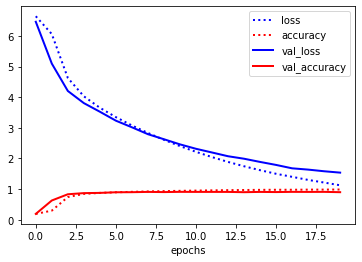

In [20]:
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Conv2D, Flatten, InputLayer, MaxPool2D

def build_model_2_1():
    model = Sequential()
    # Shape = (#, 32, 32)
    model.add(InputLayer(input_shape=(32, 32, 1)))
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same'))
    # Shape = (64, 32, 32)
    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    # Shape = (128, 28, 28)
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu', strides=2))
    # Shape = (128, 12, 12)
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    # Shape = (256, 10, 10)
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    # Shape = (256, 8, 8)
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    # Shape = (256, 6, 6)
    model.add(Flatten())
    # Shape = (9216)
    model.add(Dense(2000, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(700, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(160, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=20, batch_size=32)
answer_q_2_1 = """The pictures are centered on the numbers, so convolutional layers don't have to be padded. The first layer is padded to allow more conv layers. Filter amounts increase to maintain info and parameters. Kernelsizes shrink as images shrink to slow down shrinking. The strides are used to limit parameters as model size may not exceed 100mb. The model flattens when the images becomes too small for conv. Then 3 more dense, with decreasing nodes, are used to find patterns in the filters. All layers use relu, this keeps values positive and improves accuracy by 2%. Dropout and L2 regularization is used on dense to avoid overfitting, using L1 or L2 on conv does not help. The model achieves a 91% accuracy after 20 epochs without overfitting, but with more epochs the model will start to overfit."""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Start augmenting preprocessed images
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading model from file
Success!
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 12, 12, 128)       204928    
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_47 (Conv2D)           (None

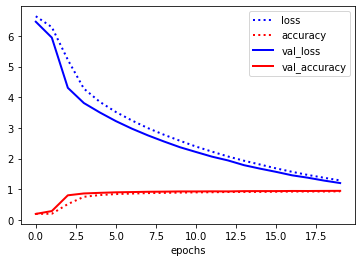

In [32]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
def random_zoom():
    return ((random.random()-0.5) / 2) + 0.75

def augment_images(preprocessed):
    # TODO: Small rotations, left-right shift, zoom
    print("Start augmenting preprocessed images")
    # create image data augmentation generator
    datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.20, width_shift_range=0.05, height_shift_range=0.05)
    # transform images
    return datagen.flow(preprocessed[0], preprocessed[2], batch_size=32)

augmenter = augment_images(preprocessed_split)
augmented_split = (augmenter, preprocessed_split[1], preprocessed_split[3])
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=False, epochs=20, batch_size=None, generator=True, steps_per_epoch=len(preprocessed_split[0]*2) // 32)
answer_q_2_2 = """Rotation and sliding of images was tried in question 1.2 and performed very poorly (19% accuracy) for obvious reasons as the changes were quite large. Random zooming and set zooming both have a 89% accuracy. Flipped (horizontal or vertical) images have a 91% accuracy, likely because they are very similar to the original images. With a 94% accuracy, the model trained on augmented data that is rotated, shifted and zoomed, is much better than the model from 2.1. As it both performs and generalizes better"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

Processing testdata

Accuracy on the testset is: 0.9433981266995669

Confusion matrix (true label on the y-axis, predicted label on the x-axis)
            1     2     3     4     5     6     7     8     9     0 Total 
    1:   3616    39    34    25    11     6    36     5     6    14  3792
    2:     16  2861    20    10     6     2    16     9     6     1  2947
    3:     16    29  2141     2    40     7     9    12    12     8  2276
    4:     37    13    16  1896     9     9     0     6     8     2  1996
    5:     10     9    62     5  1731    20     0     5    11     0  1853
    6:     11     9    17     2    30  1436     1    19     4    12  1541
    7:     45    34    29     5     2     5  1396     0     2     5  1523
    8:     11     9    25     3     8    27     1  1237    14     6  1341
    9:      6    30    18     3    14     2     2     9  1156    11  1251
    0:     14    13     9     7     3    11     1     5    11  1264  1338
Total:   3782  3046  2371  1958  1854  15

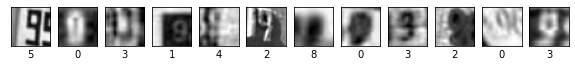

Answer is 734 characters long


In [43]:
from pprint import PrettyPrinter
tf.compat.v1.disable_eager_execution()
global graph
graph = tf.compat.v1.get_default_graph()

# processing testdata
print('Processing testdata')
processed_split = preprocess(X_test, X_test, y_test, y_test)

model_2_2 = load_model_from_file(base_dir, 'model_2_2')

def test_model(name, test_data, verbose=True):
    """return predictions"""
    # Create predictions
    with graph.as_default():
        predictions = model_2_2.predict(test_data, batch_size=128)
    return predictions

def get_accuracy(name, test_data, test_labels):
    """Use trained model with data and return accuracy"""
    # Calculate accuracy
    test_accuracy_3_1 = 0
    for prediction, true_label in zip(test_model(name, test_data), test_labels):
        if np.argmax(prediction) == np.argmax(true_label):
            test_accuracy_3_1 += 1
    return test_accuracy_3_1 / len(test_data)

test_accuracy_3_1 = get_accuracy('model_2_2', processed_split[1], processed_split[3])
print("\nAccuracy on the testset is: {}".format(test_accuracy_3_1))

def plot_confusion_matrix():
    # Create a 10 by 10 matrix
    confusion_matrix = [[0 for i in range(10)] for i in range(10)]
    # Get predictions from model
    for prediction, true_label in zip(test_model('model_2_2', processed_split[1]), processed_split[3]):
        confusion_matrix[np.argmax(true_label)][np.argmax(prediction)] += 1
    print_matrix(confusion_matrix)

def print_matrix(confusion_matrix):
    print("\nConfusion matrix (true label on the y-axis, predicted label on the x-axis)")
    # print header
    print("       " + "".join(["{:6}".format((value+1)%10) for value in range(10)]) + " {:6}".format('Total'))
    # print values
    for i in range(len(confusion_matrix)):
        print("{:5}: ".format((i+1)%10) + "".join(["{:6}".format(value) for value in confusion_matrix[i]]) + "{:6}".format(sum(confusion_matrix[i])))
    # totals
    print("Total: " + "".join(["{:6}".format(sum(x)) for x in zip(*confusion_matrix)]) + "{:6}".format(sum([sum(x) for x in confusion_matrix])))

plot_confusion_matrix()

def plot_misclassifications(name='model_2_2', test_data=processed_split[1], test_labels=processed_split[3], label=9):
    misclassified_images_of_label = []
    predictions = test_model(name, test_data)
    for prediction, true_label, index in zip(predictions, test_labels, range(len(test_labels))):
        if (np.argmax(true_label)+1)%10 == label:
            if np.argmax(prediction) != np.argmax(true_label):
                misclassified_images_of_label.append((index, prediction, true_label))
    return misclassified_images_of_label

def plot_missed_images(num_images, missed, X_test_processed):
    print("\nPrinting misclassified images of class {}".format((np.argmax(missed[0][2])+1)%10))
    num_images = 2*min(num_images, len(missed))
    plot_images([np.reshape(image, (32,32)) for image in X_test_processed[[index for index, pred, label in missed[:num_images] if index%2]]],
            [pred for index, pred, label in missed[:num_images] if index%2],
            grayscale=True)

missed = plot_misclassifications('model_2_2', processed_split[1], processed_split[3], label=9)
plot_missed_images(10, missed, processed_split[1])

answer_q_3_1 = """The accuracy on the testset is 94%, this is equal to the validation set which means that the model generalizes well. The confusion matrix shows that 3 and 5 are most often mixed, with 244 misclassifications. Additionally, a 7 is often classified as 1. These errors even happen to humans, so the model can identify numbers through some noise. Images of number 9 are shown to investigate why the model still makes mistakes. 9 was chosen because it gets predicted to other classes roughly uniform. Most of these images contain noise or backgrounds with a similar color. However, some contain a poorly written 9 such that it potentially looks like another number. Reducing noise by creating detailed images will likely remove most errors."""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [44]:
def show_activations(layer_index, activations, layer_names):
    images_per_row = 16
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

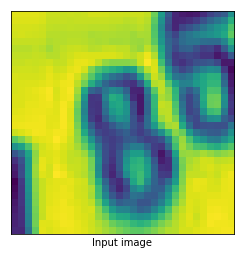

c:\users\yuri\documents\python\widm3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


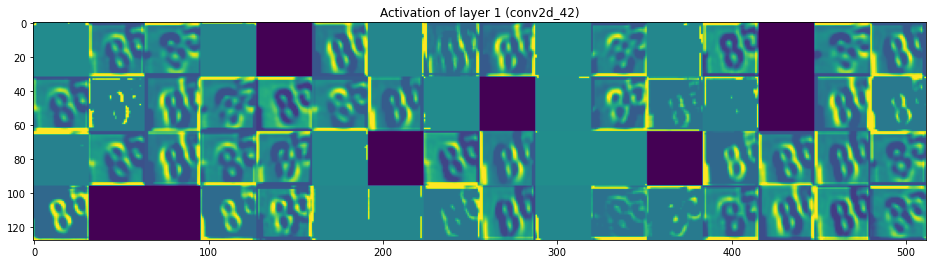

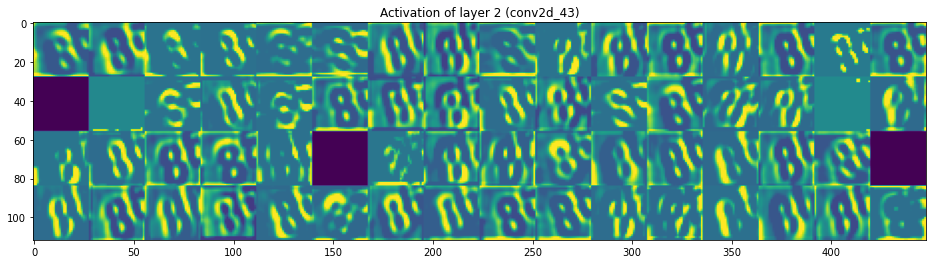

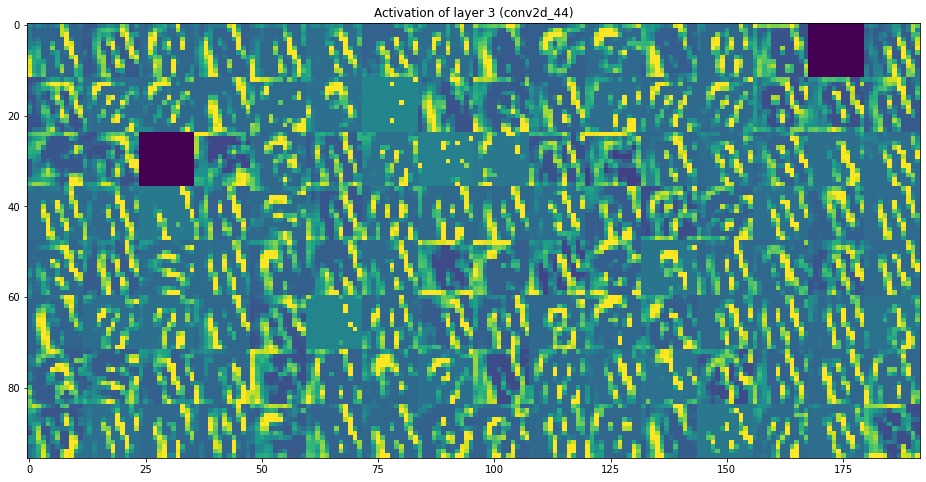

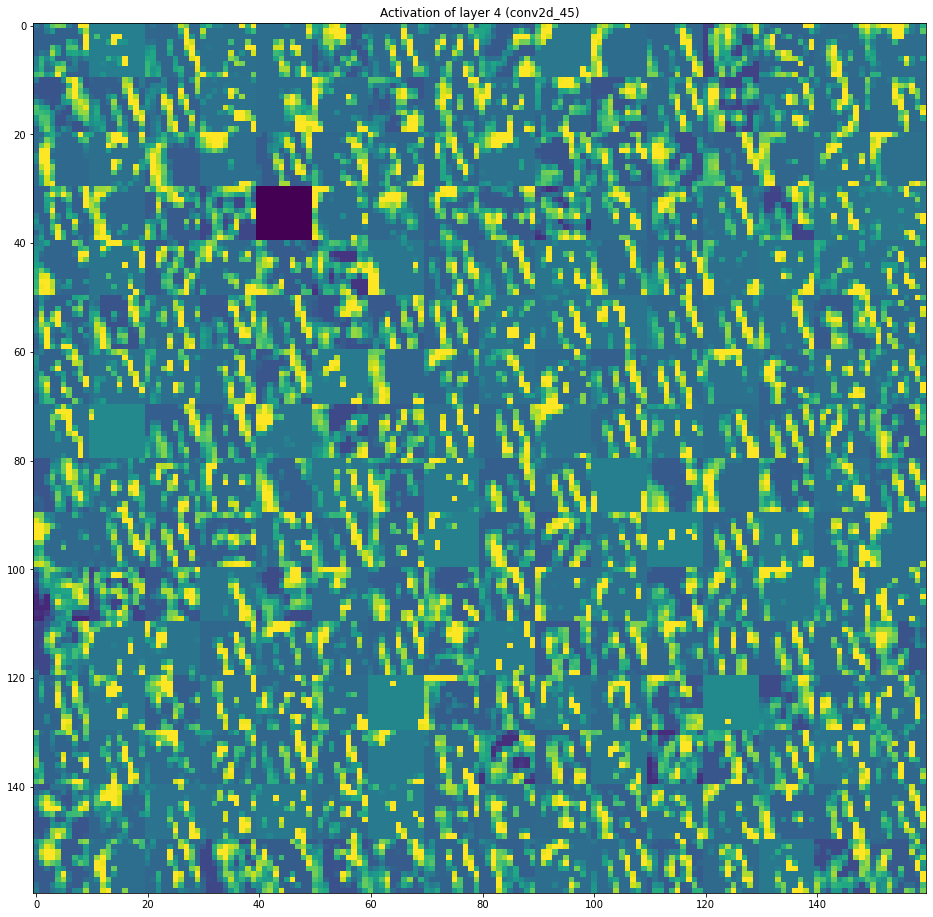

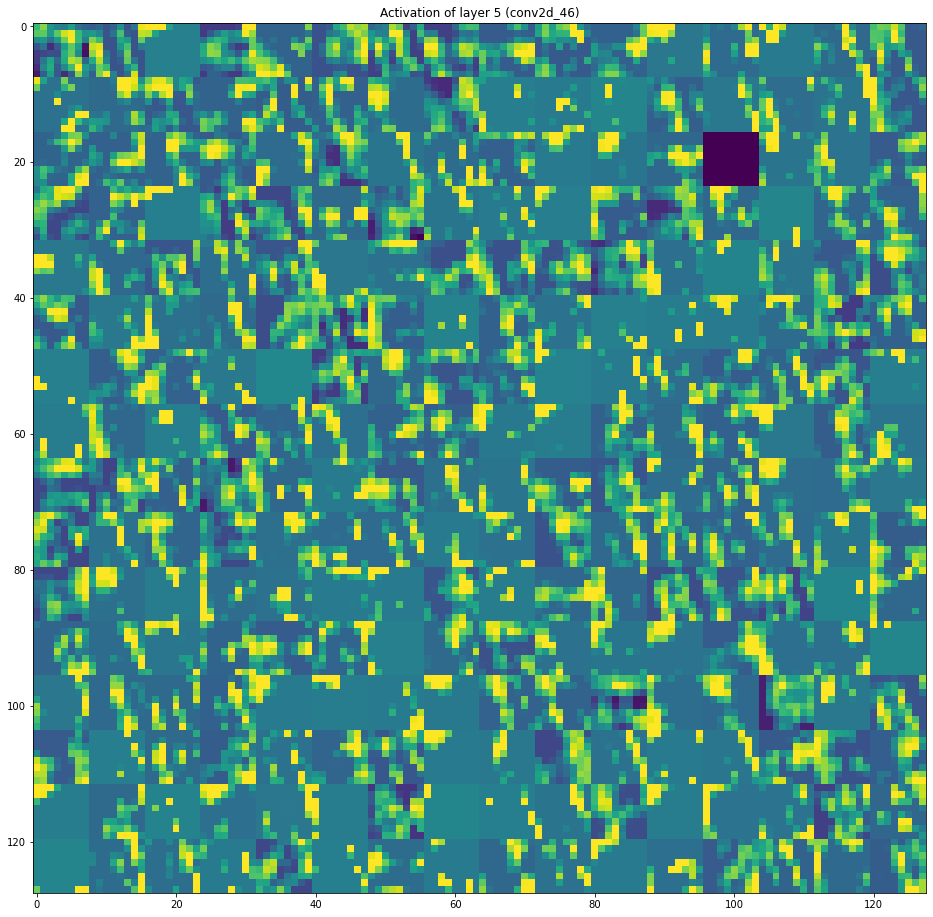

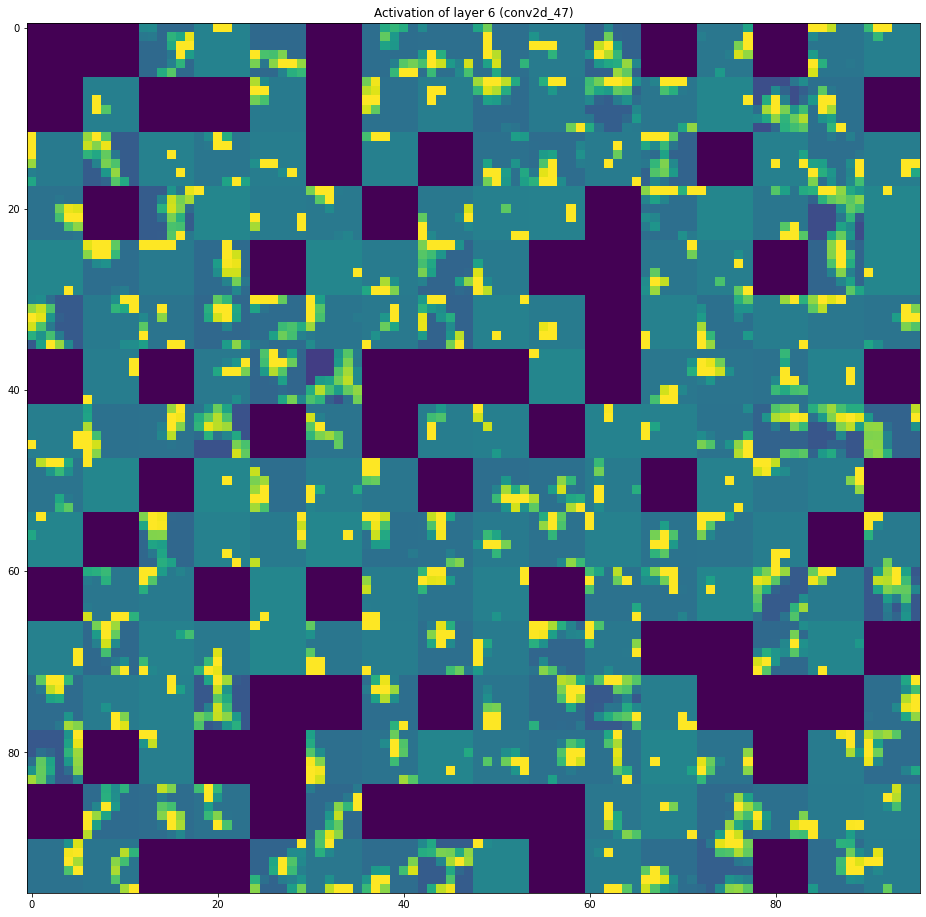

Answer is 504 characters long


In [48]:
from tensorflow.keras import models


def plot_activations(model_name='model_2_2', image=processed_split[1][0]):
    # Load model
    model = load_model_from_file(base_dir, model_name)
    if not model:
        shout("Model not found")
        return
    learning_curves = None
    try:
        learning_curves = pickle.load(open(os.path.join(base_dir, model_name+'.p'), "rb"))
    except FileNotFoundError:
        shout("Learning curves not found")
        return
    # Create activation model
    temp = np.expand_dims(image, axis=0)
    layer_outputs = [layer.output for layer in model.layers[:6]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    with graph.as_default():
        activations = activation_model.predict(temp)
    # layer names
    layer_names = []
    for layer in model.layers[:6]:
        layer_names.append(layer.name)
    # Show original input
    plt.matshow(np.reshape(temp[0], (32, 32)))
    plt.xlabel("Input image")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    # Display the activation layers
    for i in range(7):
        show_activations(i, activations, layer_names)
    # Return activations for testing purposes
    return activations

activations = plot_activations('model_2_2', processed_split[1][0])

answer_q_3_2 = """The model is definitly learning something usefull. The filters of the first convolutional layer already finds some contours of the 8 and noise is removed. The second layer emphasises these contours with a lot of filters having the 8 a distinct value from the background. The thrid layer finds and ephasises the edges of the 8, which are used by the next layers to determine what number these edges from. After the fourth layer, the filter representation and number are not recognizable for humans anymore"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


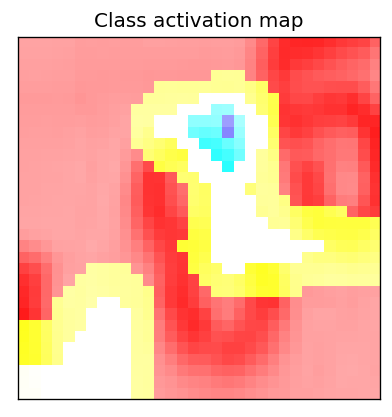

In [55]:
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2

# K.clear_session()
def plot_3_3():
    wanted_output = model_2_2.output[:, 7]
    # the last convolutional layer in model_2_2
    last_conv_layer = model_2_2.get_layer('conv2d_47')
    grads = K.gradients(wanted_output, last_conv_layer.output)[0]

    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `conv149`,
    # given a sample image
    iterate = K.function([model_2_2.input], [pooled_grads, last_conv_layer.output[0]])

    test_image = np.expand_dims(processed_split[1][0], axis=0)
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate(test_image)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = processed_split[1][0]
    heatmap = cv2.resize(heatmap, (32, 32))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    # RGB_im = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    plt.rcParams['figure.dpi'] = 120
    plt.imshow(superimposed_img)
    plt.title('Class activation map')
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Loading model from file
Success!
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 10)                5130      
Total params: 14,719,818
Trainable params: 12,984,330
Non-trainable params: 1,735,488
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.039505  0.759301  0.293720      0.852458
max  0.727410  0.988024  0.467257      0.920312
Answer is 265 characters long


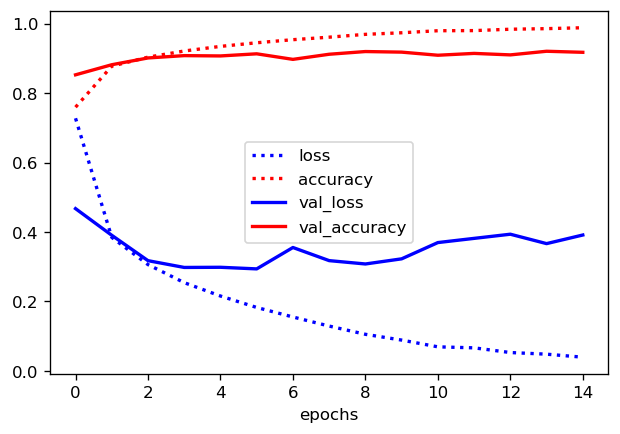

In [56]:
from tensorflow.keras.applications import VGG16


def build_model_4_1():
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    model = Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    for layer in vgg.layers:
        if layer.name in ['block4_conv1', 'block4_conv2', 'block4_conv3',
                          'block5_conv1', 'block5_conv2', 'block5_conv3']:
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
                train=False, epochs=15, batch_size=32)
answer_q_4_1 = """While the model does have an accruacy of 92%, it heavily overfits on the training data. This still happens when more parameters are frozen, but that will also decrease accuracy. Since we don't have control over most of the model, adding regularization is difficult."""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [57]:
import pickle
import gzip
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)
        
def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file """
    # Create a keras function to gain data from flatten layer
    model = load_model_from_file(base_dir, 'model_4_1')
    output_layer = model.get_layer('flatten_15').output
    func = K.function([model.input, K.learning_phase()], output_layer)
    # Embed the data in batches, then store all data
    # Note, some data gets lost
    for data, name in [(X_train_all, 'X_train'), (X_test, 'X_test')]:
        print("Embedding {}".format(name), len(data))
        embedded = [func([np.expand_dims(image, axis=0), 1.]) for image in data]
        embedded = np.array(embedded)
        print(embedded.shape)
        store_embedding(embedded, name)
        del embedded
    print("Store labels")
    store_embedding(y_train_all, 'y_train')
    store_embedding(y_test, 'y_test')

# Store embedded data on disk
stored_embeddings = True
if not stored_embeddings:
    store_embeddings()

def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    pipe = Pipeline(steps=[('classifier', RandomForestClassifier(n_jobs=-1))])
    return pipe

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
        evaluated on the supplied embedded test set. Returns the accuracy score.
        """
    print("Fitting pipeline")
    pipeline.fit(X_train, y_train)
    print("Evalaute pipeline")
    predictions = pipeline.predict(X_test)
    return sum([np.argmax(pred) == np.argmax(true) for (pred, true) in zip(predictions, y_test)]) / len(y_test)

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    return evaluate_pipeline(generate_pipeline(), X_train, y_train, X_test, y_test)

print("Loading data")
X_train = np.reshape(load_embedding('X_train'), (-1, 512))
y_train = load_embedding('y_train')
X_test = np.reshape(load_embedding('X_test'), (-1, 512))
y_test = load_embedding('y_test')
accuracy = evaluation_4_2(X_train, y_train, X_test, y_test)

print("Pipeline accuracy: {}".format(accuracy))

answer_q_4_2 = """The image embedding are made by passing the images through the trained model_4_1 and taking the output of the flatten layer. Now, every image is represented by 512. These values are stored, loaded again, and used to fit a random forest classifier. No preprocessing is used as I trust that the convolutional layers return representative values. Finally, the random forest is used on the test set to predict the class. This method has a 90,5% accuracy with room for improvement for the random forest hyperparameters."""
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Loading data
Fitting pipeline
Evalaute pipeline
Pipeline accuracy: 0.9072917715782053
Pipeline: Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)
Answer is 514 character